In [ ]:
# modeling of gene expresions predicted from 
# enformer model to predict drug repsonse (AUC). 

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import os
import copy
%matplotlib inline

### Correlation between gene expression profiles of genes

In [25]:
def show_cor(acc_id, save=False):
    df = pd.read_csv(f'/Users/jerryliu/jerry_jupyter/internship/files/Gen_exp/files/{acc_id}.csv', index_col=0)
    cor_score = df.corr()
    f = plt.figure(figsize = (10,10))
    plt.matshow(cor_score , fignum = f.number)
    cv = plt.colorbar()
    if save:
        plt.savefig(f'/Users/jerryliu/jerry_jupyter/internship/files/Gen_exp/figures/{acc_id}_corr.pdf')

In [15]:
# import gene expression matrix 
# and targets.

df = pd.read_csv('/Users/jerryliu/jerry_jupyter/internship/files/Gen_exp/SRR8670743.csv', index_col=0)

cor_score = df.corr()

In [28]:
df.shape

(680, 5313)

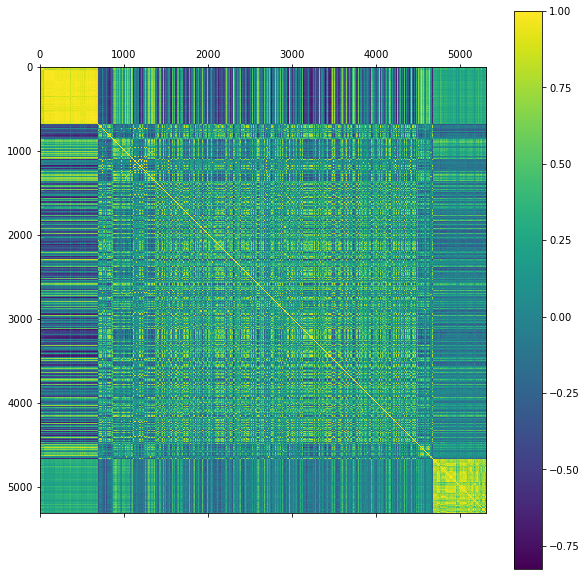

In [22]:
#plt.rcParams['figure.figsize'] = [20, 20]
f = plt.figure(figsize = (10,10))
plt.matshow(cor_score , fignum = f.number)
cv = plt.colorbar()
plt.savefig('../files/Gen_exp/figures/SRR8670743_corr.pdf')

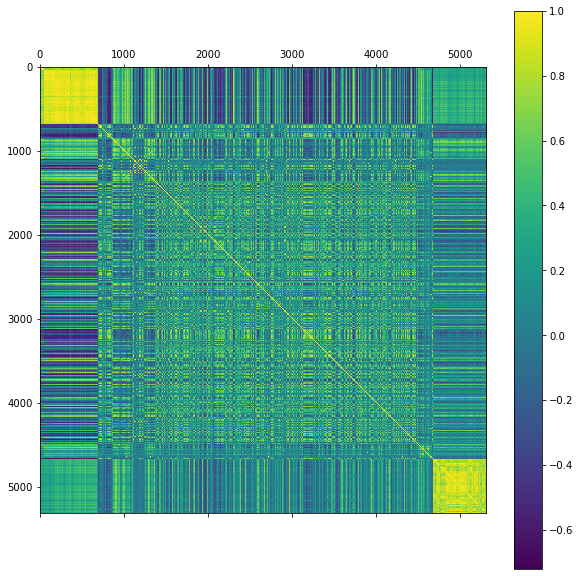

In [26]:
show_cor('SRR8788981')

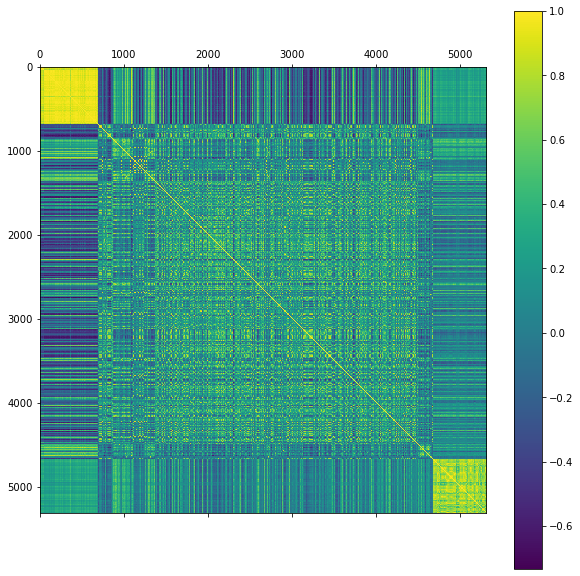

In [27]:
show_cor('SRR8788982')

### Correlation between gene expressions of samples

In [32]:
def show_cor_gene(gene_name, save=False):
    df = pd.read_csv(f'/Users/jerryliu/jerry_jupyter/internship/files/Gen_exp/ex_samples/{gene_name}.csv', index_col=0)
    cor_score = df.corr()
    f = plt.figure(figsize = (10,10))
    plt.matshow(cor_score , fignum = f.number)
    cv = plt.colorbar()
    if save:
        plt.savefig(f'/Users/jerryliu/jerry_jupyter/internship/files/Gen_exp/figures/{gene_name}_corr.pdf')

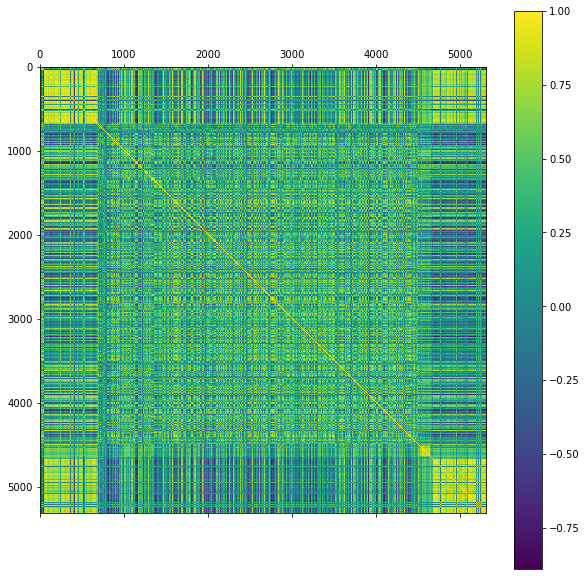

In [33]:
#g_df = pd.read_csv('../files/Gen_exp/ex_samples/ERBB4.csv',index_col = 0)
show_cor_gene('ERBB4')

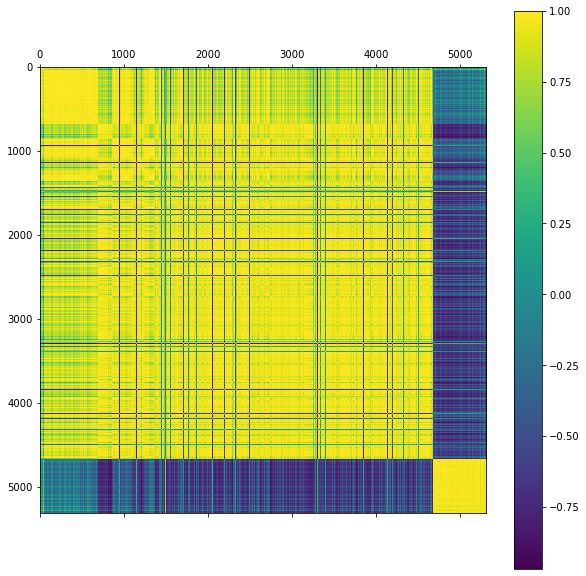

In [34]:
show_cor_gene('BRAF')

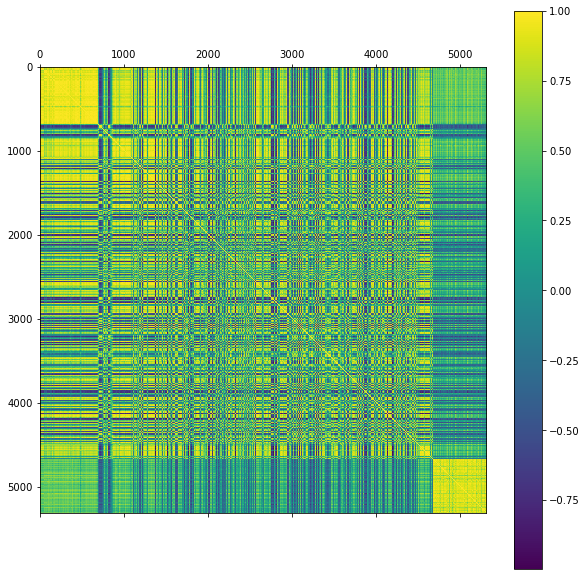

In [35]:
show_cor_gene('MAP3K1')

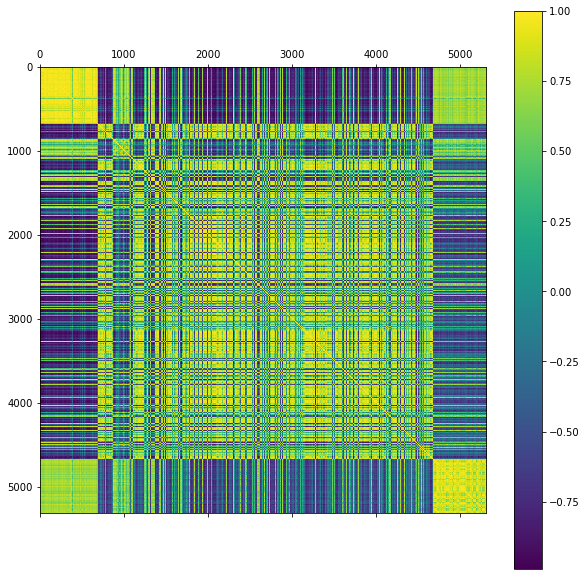

In [37]:
show_cor_gene('DDB2')

We see that gene expression profiles have good correlation cross samples, but the corelation 
relationship is different for different genes. This means the genes have their own expression context. And this could also be supported that correlation amoung genes is not good. So we should put gene expression profiles as features.

### Do PCA for each gene across 329 samples.

In [287]:
import PCAmodules 
import importlib
importlib.reload(ElasticNetModules)
from ElasticNetModules import EN_cv_in, out_loop, drug_model

In [256]:
# make (gene, dataframe) lists.
file_path = '/Users/jerryliu/jerry_jupyter/internship/files/Gen_exp/ex_samples/'
def gene_generator(file_path):
    for i in os.listdir(file_path):
        if i.endswith('.csv'):
            yield {'name' : i.split('.')[0],
                   'df' : pd.read_csv(file_path+i, index_col=0)}
    
gene_dict = {i.split('.')[0]: pd.read_csv(file_path+i, index_col=0) 
             for i in os.listdir(file_path) if i.endswith('.csv')}


In [257]:
df = pd.DataFrame()
for index,gene_item in enumerate(gene_generator(file_path)):
    #load data
    GENE = PCAmodules.PCA_gene(**gene_item)
    print(f'processing {GENE.name}, dimension: {GENE.df.shape}.')
    #normalize the data
    scaled_x = GENE.normalize()
    
    #conduct pca
    ncps, exlained_var_ratio = GENE.do_pca(ex_var = 0.8)
    #transform the data to number of components that satisfy the 
    # variance. 
    transformed_x = GENE.transform() #np.array
    print(f"dimension after PCA: {transformed_x.shape}")
    
    df_ = pd.DataFrame(transformed_x , columns=[f'{GENE.name}_cp_{i+1}'for i in range(ncps)], 
                      index = gene_item['df'].index )
    df = pd.concat([df,df_], axis=1)
    

processing MAP3K1, dimension: (329, 5313).
dimension after PCA: (329, 4)
processing BRAF, dimension: (329, 5313).
dimension after PCA: (329, 2)
processing ERBB4, dimension: (329, 5313).
dimension after PCA: (329, 7)
processing DDB2, dimension: (329, 5313).
dimension after PCA: (329, 2)


In [258]:
df.head()

MAP3K1_cp_1  MAP3K1_cp_2  MAP3K1_cp_3  MAP3K1_cp_4  BRAF_cp_1  \
SRR8639199   -54.248255    39.495834     8.183285   -23.893425 -22.036849   
SRR8639190    49.858142   -36.314060   -15.774116     4.019518 -20.267386   
SRR8639200   -59.407437    -7.181619    29.665835    11.893319 -23.992286   
SRR8639194   -27.568376    15.735280   -23.774942    -6.389160 -25.834877   
SRR8639187   -16.980776   -18.191963   -28.301964   -17.366750 -22.926002   

            BRAF_cp_2  ERBB4_cp_1  ERBB4_cp_2  ERBB4_cp_3  ERBB4_cp_4  \
SRR8639199 -32.144062  -13.589388   41.419118   18.122182    5.929506   
SRR8639190  23.783528  -38.279435  -32.757613  -30.395005   -2.180210   
SRR8639200  14.064831   37.375599  -21.143661   -3.966442    6.048613   
SRR8639194   6.213807   36.014292  -41.730977    7.759660   33.505907   
SRR8639187  -6.275703   90.548081   -6.000140   21.388214   -5.944532   

            ERBB4_cp_5  ERBB4_cp_6  ERBB4_cp_7  DDB2_cp_1  DDB2_cp_2  
SRR8639199   -4.814254  -12.376103    1.549127 -27.115169  18.895989  
SRR8639190   -5.920375  -16.811049   -6.231212   5.651157   2.165492  
SRR8639200  -11.372890   22.955866   -7.755897 -46.171210  26.952090  
SRR8639194  -14.687562   17.355174  -23.605219 -16.804815  21.252923  
SRR8639187  -15.000562    0.583518  -12.190219 -35.250206 -11.539547

### Build elasticNet to predict target

#### upload X and Y

In [269]:
x = pd.read_csv('/Users/jerryliu/jerry_jupyter/internship/files/PCA_0.8.csv', index_col = 0)
print(x.shape)
x.head()

(329, 2294)


NOTCH2_cp_1  NOTCH2_cp_2  NOTCH2_cp_3  NOTCH2_cp_4  NOTCH2_cp_5  \
SRR8639199    -7.187660    18.321424    10.211830   -27.260515     0.793223   
SRR8639190    24.661145    -2.332398   -45.987085    -4.860768     0.645907   
SRR8639200    40.309603   -25.051534    17.275631   -10.464018    -6.627654   
SRR8639194    -5.198318    -5.904502   -20.464362     8.903249    -4.106289   
SRR8639187    69.851656    35.648792    -6.282647   -14.107688     1.387296   

            NOTCH2_cp_6  NOTCH2_cp_7   SKI_cp_1   SKI_cp_2   SKI_cp_3  ...  \
SRR8639199    -8.568187    -3.748108 -32.824167  17.317690   3.612847  ...   
SRR8639190    -9.397868    21.665101   0.220581  -5.502600 -46.365586  ...   
SRR8639200    -3.134668     3.404640 -15.998003  31.568151  17.440956  ...   
SRR8639194   -14.708256   -11.069034  -5.789033 -27.074987   1.466313  ...   
SRR8639187   -20.220978     2.361430 -23.606862  28.575411 -21.490346  ...   

            FLNA_cp_5  FLNA_cp_6  FLNA_cp_7  FLNA_cp_8  RPL10_cp_1  \
SRR8639199 -14.211848 -10.410054   2.357262   1.291481  -35.813104   
SRR8639190  -0.590009  -8.486036  -3.135681   9.811792  -27.726369   
SRR8639200  22.015192   1.534417  -6.498076   9.670091  -13.416055   
SRR8639194  10.285158   3.624754  -5.415276  -4.721859   -3.600662   
SRR8639187  -9.804610  -0.764000   2.908548   5.130634  -33.298115   

            RPL10_cp_2  MTCP1_cp_1  MTCP1_cp_2  MTCP1_cp_3  MTCP1_cp_4  
SRR8639199   -5.115124   -5.849209  -26.797411    5.338512    2.817315  
SRR8639190  -10.805216   93.350478    2.836394  -51.612183   -5.754692  
SRR8639200  -10.010687   -2.147015  -25.898614    3.265286    0.848221  
SRR8639194   -8.631479  -13.006519  -12.522340   15.142715   -9.984382  
SRR8639187   -3.580768  -25.861919   65.020468  -21.981554   -1.571488  

[5 rows x 2294 columns]

In [271]:
df = x

In [272]:
# Import target vector
drug_file = "/Users/jerryliu/Documents/Vu_uva/internship/CCLE/Drug_sensitivity_AUC.csv"
sra_info = "/Users/jerryliu/Documents/Vu_uva/internship/CCLE/sra_result.csv"
run_info = "/Users/jerryliu/Documents/Vu_uva/internship/CCLE/SraRunInfo.csv"
sample_info_file = "/Users/jerryliu/Documents/Vu_uva/internship/CCLE/sample_info.csv"
pd.options.mode.chained_assignment = None  # default='warn

In [273]:
# eliminate drug repsonse with multiple drug treatment. 
drug_df = pd.read_csv(drug_file, index_col = 0)
drug_df = drug_df.iloc[:,drug_df.columns.map(lambda x:len(x.split('(CTRP')[0].strip().split(' ')[0].split(':')) == 1)]
drug_df.columns = drug_df.columns.map(lambda x:x.split('(CTRP')[0].strip())
drug_df.shape
drug_df.head()

CIL56   FQI-1  BRD-K92856060     B02  BRD6340  BRD-K45681478  \
ACH-000002     NaN     NaN         13.349  12.987   14.904         13.517   
ACH-000004  11.733  10.825         13.911  13.445   14.193         15.000   
ACH-000005     NaN     NaN         13.646  12.313   13.739         13.328   
ACH-000006     NaN     NaN            NaN     NaN   14.016         11.103   
ACH-000007  14.562  11.469         14.418  12.920   14.742         12.056   

             ML050    ML162   CIL41   ML006  ...  AT13387  BCL-LZH-4  \
ACH-000002  14.709  10.4670     NaN  14.634  ...   7.0509     15.139   
ACH-000004  15.689   7.0524  14.780  14.513  ...      NaN        NaN   
ACH-000005  14.662   6.7487     NaN  14.532  ...   4.3041     14.460   
ACH-000006     NaN   9.8786     NaN     NaN  ...      NaN        NaN   
ACH-000007  15.638   8.5650  15.313  14.302  ...      NaN        NaN   

            skepinone-L  BRD-K34222889  PF-4800567  avicin D  BRD-K30748066  \
ACH-000002       14.489        10.7010      15.740   12.6930            NaN   
ACH-000004          NaN         9.9767         NaN       NaN            NaN   
ACH-000005       13.254        10.5430      14.575    9.9691            NaN   
ACH-000006          NaN         9.2081         NaN       NaN            NaN   
ACH-000007          NaN        10.5100         NaN       NaN            NaN   

            linsitinib  AT-406   ML031  
ACH-000002      11.682  14.231  13.676  
ACH-000004      16.917     NaN  15.715  
ACH-000005      16.538  14.004  12.914  
ACH-000006      12.054  13.839     NaN  
ACH-000007      11.212     NaN  14.694  

[5 rows x 494 columns]

In [274]:
# Read sample_infor to map Depmap ID to CCLE name
sample_info = pd.read_csv(sample_info_file)
#np.isin(sample_info.loc[:,'DepMap_ID'], drug_df.index)
mapping = sample_info.loc[np.isin(sample_info.loc[:,'DepMap_ID'], drug_df.index),['DepMap_ID', 'CCLE_Name']]

In [275]:
# Read run_infor to map Run name to CCLE name
run_info_ = pd.read_csv(run_info)
run_info_.set_index(['Run'], inplace=True )
run_info_ = run_info_.loc[:,'SampleName']

In [276]:
# Take the intersection of drug file and 329-sample file.
consens_id = mapping.loc[np.isin(mapping.CCLE_Name, run_info_.values),:]
consens_id.loc[:,'Run'] = run_info_[np.isin(run_info_.values, mapping.CCLE_Name)].index.copy()

In [277]:
drug_df = drug_df.loc[consens_id.DepMap_ID,:]

In [278]:
drug_df.reset_index(inplace=True)
drug_df.loc[:,'Run'] = consens_id.set_index('DepMap_ID').loc[drug_df.loc[:,'index'],:].Run.values
drug_df.set_index(['index','Run'], inplace=True)
drug_df

CIL56   FQI-1  BRD-K92856060     B02  BRD6340  \
index      Run                                                          
ACH-000005 SRR8788980     NaN     NaN         13.646  12.313   13.739   
ACH-000007 SRR8788981  14.562  11.469         14.418  12.920   14.742   
ACH-000008 SRR8788982     NaN     NaN         14.840  11.826   14.890   
ACH-000009 SRR8670688     NaN     NaN         12.333  13.680   13.944   
ACH-000012 SRR8670687  11.715  12.065         14.963  13.432   14.036   
...                       ...     ...            ...     ...      ...   
ACH-001129 SRR8639238  12.214  11.205         13.636  13.183   14.124   
ACH-001190 SRR8639237     NaN     NaN         14.937  12.599   14.895   
ACH-001239 SRR8639240     NaN     NaN         14.642  12.827   14.509   
ACH-001306 SRR8639239  11.239  12.076         15.000  12.489   14.210   
ACH-001318 SRR8639232     NaN     NaN         14.899  12.697   14.677   

                       BRD-K45681478   ML050    ML162   CIL41   ML006  ...  \
index      Run                                                         ...   
ACH-000005 SRR8788980         13.328  14.662   6.7487     NaN  14.532  ...   
ACH-000007 SRR8788981         12.056  15.638   8.5650  15.313  14.302  ...   
ACH-000008 SRR8788982         14.380  14.620  10.4550     NaN  14.418  ...   
ACH-000009 SRR8670688         11.797  14.447  10.1570     NaN  13.251  ...   
ACH-000012 SRR8670687         15.000  14.878   7.5232  14.609  14.370  ...   
...                              ...     ...      ...     ...     ...  ...   
ACH-001129 SRR8639238         11.328  13.744   8.0446  14.746  12.040  ...   
ACH-001190 SRR8639237         14.909  13.981  12.7520     NaN  16.449  ...   
ACH-001239 SRR8639240         12.902  14.887   9.8569     NaN  12.530  ...   
ACH-001306 SRR8639239         12.784  15.576   6.3445  12.727  14.332  ...   
ACH-001318 SRR8639232         14.438  14.599  10.6010     NaN  13.378  ...   

                       AT13387  BCL-LZH-4  skepinone-L  BRD-K34222889  \
index      Run                                                          
ACH-000005 SRR8788980   4.3041     14.460       13.254         10.543   
ACH-000007 SRR8788981      NaN        NaN          NaN         10.510   
ACH-000008 SRR8788982  12.0260     15.061       14.924         11.997   
ACH-000009 SRR8670688   7.4379     14.112       13.857         12.149   
ACH-000012 SRR8670687      NaN        NaN          NaN         10.834   
...                        ...        ...          ...            ...   
ACH-001129 SRR8639238      NaN        NaN          NaN          8.967   
ACH-001190 SRR8639237  17.4780     14.316       13.675            NaN   
ACH-001239 SRR8639240   6.1059     14.653       13.500         11.106   
ACH-001306 SRR8639239      NaN        NaN          NaN         10.745   
ACH-001318 SRR8639232   6.9678     14.868       13.956         11.676   

                       PF-4800567  avicin D  BRD-K30748066  linsitinib  \
index      Run                                                           
ACH-000005 SRR8788980      14.575    9.9691            NaN      16.538   
ACH-000007 SRR8788981         NaN       NaN            NaN      11.212   
ACH-000008 SRR8788982      14.718   10.7490            NaN      14.383   
ACH-000009 SRR8670688      13.652   10.9720            NaN      13.265   
ACH-000012 SRR8670687         NaN       NaN            NaN      15.704   
...                           ...       ...            ...         ...   
ACH-001129 SRR8639238         NaN       NaN            NaN      13.731   
ACH-001190 SRR8639237      14.336   10.8990            NaN      14.999   
ACH-001239 SRR8639240      14.526    9.3603            NaN      14.694   
ACH-001306 SRR8639239         NaN       NaN            NaN      14.621   
ACH-001318 SRR8639232      14.795   10.6190            NaN      14.660   

                       AT-406   ML031  
index      Run                         
ACH-000005 SRR8788980  14.004  12.914  
ACH-000007 SRR8788981     

In [279]:
df = df.loc[consens_id.Run,:].reset_index()
df.loc[:,'DepMap_ID'] = consens_id.DepMap_ID.values
df.set_index(['DepMap_ID', 'index'], inplace=True)
df_ = df
df_

NOTCH2_cp_1  NOTCH2_cp_2  NOTCH2_cp_3  NOTCH2_cp_4  \
DepMap_ID  index                                                            
ACH-000005 SRR8788980    17.779016   -17.598637   -15.649510     0.272974   
ACH-000007 SRR8788981   -34.373069     9.549242    -8.202897    28.415657   
ACH-000008 SRR8788982   -50.937598     1.856445     2.235151    -3.292195   
ACH-000009 SRR8670688    52.038828   -27.475526    23.016133    21.536051   
ACH-000012 SRR8670687    60.916630     0.968759   -35.801399    -6.499405   
...                            ...          ...          ...          ...   
ACH-001129 SRR8639238    45.641877    16.781371   -41.224279   -24.278315   
ACH-001190 SRR8639237   -46.736614    23.554468    -0.347770    28.707102   
ACH-001239 SRR8639240   -37.169429    -7.738758     5.734957    25.746160   
ACH-001306 SRR8639239   -49.035582   -23.895498     2.992872    -2.286838   
ACH-001318 SRR8639232   -29.132086     5.143591    -6.566899   -24.224764   

                       NOTCH2_cp_5  NOTCH2_cp_6  NOTCH2_cp_7   SKI_cp_1  \
DepMap_ID  index                                                          
ACH-000005 SRR8788980    13.045872     8.401284     7.833530 -12.782748   
ACH-000007 SRR8788981     8.573965   -13.234257     7.421866 -23.009736   
ACH-000008 SRR8788982    -4.704877     2.868069    -7.010478 -38.005342   
ACH-000009 SRR8670688    -5.989308    -5.746773    -5.895133 -10.895691   
ACH-000012 SRR8670687    14.926720    -2.978857     4.570480 -37.983861   
...                            ...          ...          ...        ...   
ACH-001129 SRR8639238   -12.134934     0.108250     6.450896 -24.246287   
ACH-001190 SRR8639237    -6.368268    -9.776202   -11.668410 -20.803074   
ACH-001239 SRR8639240    -9.064941   -10.065415    -1.497725 -33.331902   
ACH-001306 SRR8639239     2.122203     0.295697    25.292768   6.650262   
ACH-001318 SRR8639232     0.039026     9.843736   -12.144953 -33.866288   

                        SKI_cp_2   SKI_cp_3  ...  FLNA_cp_5  FLNA_cp_6  \
DepMap_ID  index                             ...                         
ACH-000005 SRR8788980   3.746623   6.333831  ...   1.102402  -3.372402   
ACH-000007 SRR8788981 -17.366961 -18.412456  ...  18.224077   1.776423   
ACH-000008 SRR8788982 -15.657455  13.930876  ...  -7.223836  10.144321   
ACH-000009 SRR8670688 -31.511484 -51.085729  ... -22.726299   8.732870   
ACH-000012 SRR8670687  24.176871 -32.383816  ...  -1.815000  -2.564338   
...                          ...        ...  ...        ...        ...   
ACH-001129 SRR8639238  20.030688  -9.234855  ... -11.738234  -4.357364   
ACH-001190 SRR8639237  27.007104  34.856618  ...  21.695515   4.396691   
ACH-001239 SRR8639240 -12.069340  27.915796  ...   4.369612  16.851413   
ACH-001306 SRR8639239 -18.178942  19.714484  ...  -6.972441  11.691298   
ACH-001318 SRR8639232  25.568830 -20.169641  ...  -9.529145  16.448926   

                       FLNA_cp_7  FLNA_cp_8  RPL10_cp_1  RPL10_cp_2  \
DepMap_ID  index                                                      
ACH-000005 SRR8788980   0.055848  -2.675037   14.928893   13.068200   
ACH-000007 SRR8788981 -11.456025   5.662280  -22.482935  -12.106108   
ACH-000008 SRR8788982  13.552386 -13.670654  -74.045885   52.962230   
ACH-000009 SRR8670688  -1.951686  -0.246193  -17.875367   -8.183163   
ACH-000012 SRR8670687  -0.981799   9.402613  -35.943750   -0.083360   
...                          ...        ...         ...         ...   
ACH-001129 SRR8639238   7.220210 -17.793015   47.402722   11.081725   
ACH-001190 SRR8639237 -14.148441   7.680895  -21.224762  -10.798734   
ACH-001239 SRR8639240  -2.223755   0.822203   -4.139041   -1.786023   
ACH-001306 SRR8639239 -17.218488 -19.121343   -5.265564   -2.802772   
ACH-001318 SRR8639232  -3.547677  -2.880643   24.185443   19.323345   

                       MTCP1_cp_1  MTCP1_cp_2  MTCP1_cp_3  MTCP1_cp_4  
DepMap_ID  index                                                       
ACH-000005 SRR

#### Build model

In [280]:
# get rid of drugs with too many missing values.
thresh  = int(df.shape[0]*(0.80)) ## at least 80% of Non-na value in each drug
drug_df_ = drug_df.dropna(axis = 1, thresh = thresh)
print(f'before filtering drugs: the number of drugs is {drug_df.shape[1]}')
print(f'after filtering, the number of drugs is {drug_df_.shape[1]}')
print(f'Shape of drug data: {drug_df_.shape}')
drug_df.head()

before filtering drugs: the number of drugs is 494
after filtering, the number of drugs is 359
Shape of drug data: (291, 359)


CIL56   FQI-1  BRD-K92856060     B02  BRD6340  \
index      Run                                                          
ACH-000005 SRR8788980     NaN     NaN         13.646  12.313   13.739   
ACH-000007 SRR8788981  14.562  11.469         14.418  12.920   14.742   
ACH-000008 SRR8788982     NaN     NaN         14.840  11.826   14.890   
ACH-000009 SRR8670688     NaN     NaN         12.333  13.680   13.944   
ACH-000012 SRR8670687  11.715  12.065         14.963  13.432   14.036   

                       BRD-K45681478   ML050    ML162   CIL41   ML006  ...  \
index      Run                                                         ...   
ACH-000005 SRR8788980         13.328  14.662   6.7487     NaN  14.532  ...   
ACH-000007 SRR8788981         12.056  15.638   8.5650  15.313  14.302  ...   
ACH-000008 SRR8788982         14.380  14.620  10.4550     NaN  14.418  ...   
ACH-000009 SRR8670688         11.797  14.447  10.1570     NaN  13.251  ...   
ACH-000012 SRR8670687         15.000  14.878   7.5232  14.609  14.370  ...   

                       AT13387  BCL-LZH-4  skepinone-L  BRD-K34222889  \
index      Run                                                          
ACH-000005 SRR8788980   4.3041     14.460       13.254         10.543   
ACH-000007 SRR8788981      NaN        NaN          NaN         10.510   
ACH-000008 SRR8788982  12.0260     15.061       14.924         11.997   
ACH-000009 SRR8670688   7.4379     14.112       13.857         12.149   
ACH-000012 SRR8670687      NaN        NaN          NaN         10.834   

                       PF-4800567  avicin D  BRD-K30748066  linsitinib  \
index      Run                                                           
ACH-000005 SRR8788980      14.575    9.9691            NaN      16.538   
ACH-000007 SRR8788981         NaN       NaN            NaN      11.212   
ACH-000008 SRR8788982      14.718   10.7490            NaN      14.383   
ACH-000009 SRR8670688      13.652   10.9720            NaN      13.265   
ACH-000012 SRR8670687         NaN       NaN            NaN      15.704   

                       AT-406   ML031  
index      Run                         
ACH-000005 SRR8788980  14.004  12.914  
ACH-000007 SRR8788981     NaN  14.694  
ACH-000008 SRR8788982  13.369  12.466  
ACH-000009 SRR8670688  14.510  13.534  
ACH-000012 SRR8670687     NaN  14.583  

[5 rows x 494 columns]

In [297]:
list(drug_df_.columns).index('tanespimycin')

175

In [315]:
import importlib
importlib.reload(ElasticNetModules)
from ElasticNetModules import EN_cv_in, out_loop, drug_model

processing drug: BRD-K92856060
### normalize with mean=0, std = 1.
number of features selected 2291
Dimension of the final matrix: (262, 2291)
iteration 0 begains
{(0.2, 3.059023205018258e-07): 0.032908462863567946, (0.2, 2.2603294069810542e-06): 0.032908462863567946, (0.2, 1.670170079024566e-05): 0.032908462863567946, (0.2, 0.00012340980408667956): 0.09261155935655502, (0.2, 0.0009118819655545162): 0.1354269761234177, (0.2, 0.006737946999085467): 0.1094145476332641, (0.2, 0.049787068367863944): 0.10228982338565965, (0.2, 0.36787944117144233): 0.09915328912506946, (0.2, 2.718281828459045): 0.12158711144319481, (0.2, 20.085536923187668): nan, (0.4, 3.059023205018258e-07): 0.032908462863567946, (0.4, 2.2603294069810542e-06): 0.032908462863567946, (0.4, 1.670170079024566e-05): 0.032908462863567946, (0.4, 0.00012340980408667956): 0.09250806620412638, (0.4, 0.0009118819655545162): 0.12435926526728577, (0.4, 0.006737946999085467): 0.09647689883452792, (0.4, 0.049787068367863944): 0.085082812

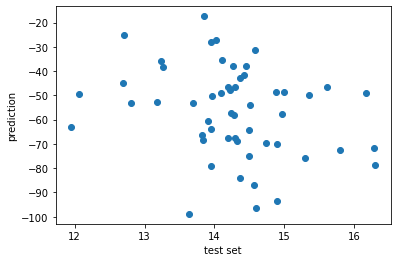

KeyboardInterrupt: 

In [316]:
#build model for each drug.
"""Training schema: 1. Bootstrapping 80% of the data (FUNCTION "drug_model")
                    2. Outter loop to split resampled data into 5-folds for training and 
                         validation (implemented in FUNCTION "out_loop" )
                    3. During each iteration of training, apply inner 10-fold loop cross 
                       validation to select best l1 ratio and alpha pair. (FUNCTION EN_cv_in)
                    4. Vaildate on the 5th fold testing set. 
""" 

comp_index = 0
target = drug_df_.iloc[:,comp_index]
out_path = '.'
pre = drug_model(df_, target, out_path=out_path) 

